## Random Forest custom implementation

Key Components of Random Forest

- Bootstrap Aggregating (Bagging): Train multiple decision trees on random subsets of the data.

- Feature Subsampling: At each split, consider only a random subset of features.

- Majority Voting: Combine predictions from all trees to make the final decision.



In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../../src/cleaned_data/cleaned_data.csv')

In [3]:
def gini_impurity(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

In [4]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, size=n_samples, replace=True)
    return X[idxs], y[idxs]

Decision Tree Node Class

In [5]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature      # Feature index to split on
        self.threshold = threshold  # Threshold value for the split
        self.left = left            # Left child node (<= threshold)
        self.right = right          # Right child node (> threshold)
        self.value = value          # Class label (for leaf nodes)

    def is_leaf(self):
        return self.value is not None

Decision Tree Class

In [6]:
class DecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features  # Number of features to consider per split
        self.root = None

    def fit(self, X, y):
        # Set number of features to use (default: sqrt(n_features))
        self.n_features = X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria
        if (depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Randomly select features to consider
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # Find best split
        best_feat, best_thresh = self._best_split(X, y, feat_idxs)

        # Split data
        left_idxs = X[:, best_feat] <= best_thresh
        X_left, y_left = X[left_idxs], y[left_idxs]
        X_right, y_right = X[~left_idxs], y[~left_idxs]

        # Grow children recursively
        left_child = self._grow_tree(X_left, y_left, depth + 1)
        right_child = self._grow_tree(X_right, y_right, depth + 1)
        return Node(best_feat, best_thresh, left_child, right_child)

    def _best_split(self, X, y, feat_idxs):
        best_gini = float('inf')
        split_idx, split_thresh = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thresh in thresholds:
                # Calculate Gini impurity for the split
                left_idxs = X_column <= thresh
                gini = self._gini_gain(y, left_idxs)

                if gini < best_gini:
                    best_gini = gini
                    split_idx = feat_idx
                    split_thresh = thresh

        return split_idx, split_thresh

    def _gini_gain(self, y, left_idxs):
        # Weighted Gini impurity after split
        n = len(y)
        n_left, n_right = np.sum(left_idxs), n - np.sum(left_idxs)
        
        if n_left == 0 or n_right == 0:
            return float('inf')
        
        gini_left = gini_impurity(y[left_idxs])
        gini_right = gini_impurity(y[~left_idxs])
        return (n_left * gini_left + n_right * gini_right) / n

    def _most_common_label(self, y):
        return Counter(y).most_common(1)[0][0]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

Random Forest Class

In [7]:
class RandomForest:
    def __init__(self, n_trees=100, max_depth=10, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features  # Default: sqrt(n_features)
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                n_features=self.n_features
            )
            X_sample, y_sample = bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.round(np.mean(tree_preds, axis=0)).astype(int)  # Majority vote

Train and Evaluate

In [8]:
# Load your data (assuming X and y are numpy arrays)
X = df.drop('Label', axis=1).values
y = df['Label'].values

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Initialize and train the model
rf = RandomForest(
    n_trees=100,
    max_depth=10,
    min_samples_split=2,
    n_features=int(np.sqrt(X.shape[1]))  # Use sqrt(n_features) for classification
)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)


In [10]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.4f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

Accuracy: 99.8824%

Confusion Matrix:
[[900   2]
 [  0 798]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       902
           1       1.00      1.00      1.00       798

    accuracy                           1.00      1700
   macro avg       1.00      1.00      1.00      1700
weighted avg       1.00      1.00      1.00      1700



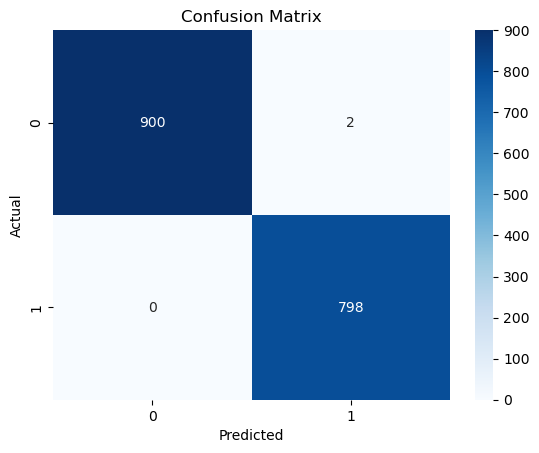

In [11]:
# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()